In [5]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

print("PyTorch :", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :", device)

PROJECT_DIR = os.getcwd()
print("Project dir :", PROJECT_DIR)


PyTorch : 2.9.1+cpu
Device : cpu
Project dir : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\project


In [7]:
# Dossier original
DATASET_ORIG = os.path.join(PROJECT_DIR, "RealWaste")

# Dossier avec fond sable
SAND_DIR = os.path.join(PROJECT_DIR, "Sand")
DATASET_SAND = os.path.join(PROJECT_DIR, "RealWaste_sand")

# Dossiers split
TRAIN_DIR = os.path.join(PROJECT_DIR, "train")
TEST_DIR  = os.path.join(PROJECT_DIR, "test")

os.makedirs(DATASET_SAND, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

print("Dataset original :", DATASET_ORIG)
print("Dossier sable    :", SAND_DIR)
print("Dataset sable BG :", DATASET_SAND)


Dataset original : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\project\RealWaste
Dossier sable    : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\project\Sand
Dataset sable BG : c:\Users\paull\OneDrive - De Vinci\Bureau\Cours esilv\A4\Semestre 1\Green AI\project\RealWaste_sand


Classes : ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


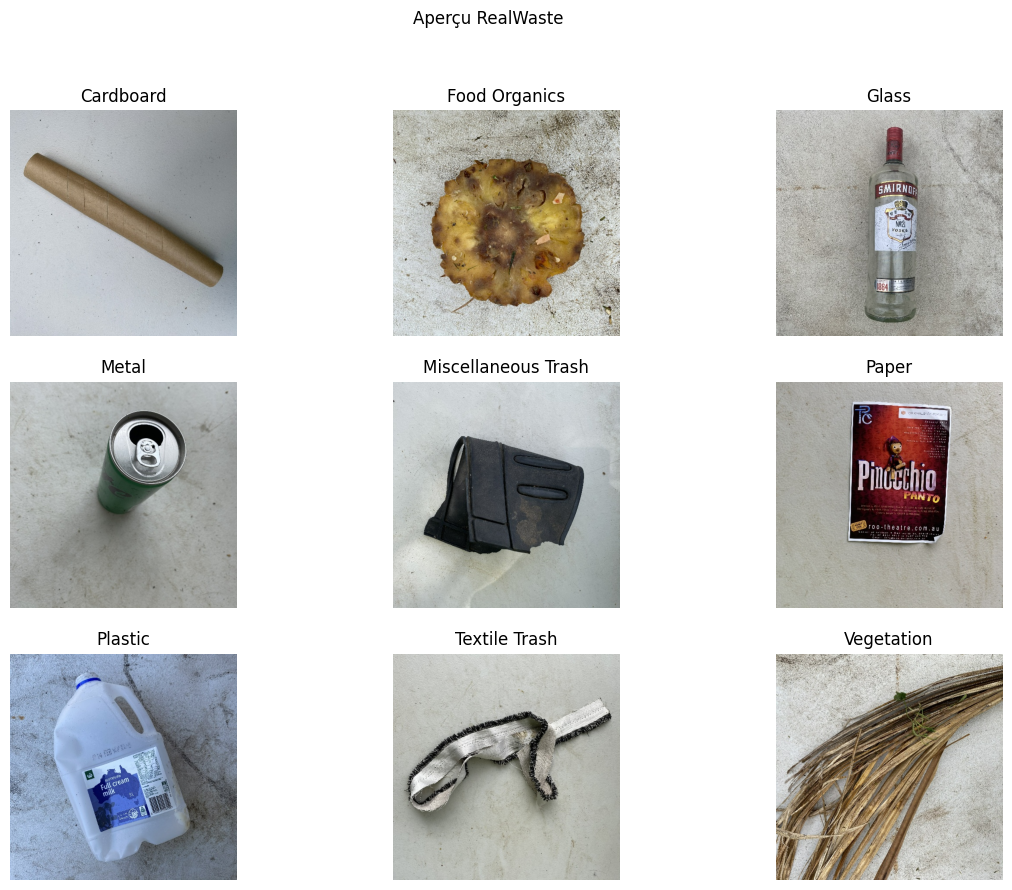

In [8]:
classes = sorted([
    c for c in os.listdir(DATASET_ORIG)
    if os.path.isdir(os.path.join(DATASET_ORIG, c))
])

print("Classes :", classes)

plt.figure(figsize=(14,10))
for i, cls in enumerate(classes[:9]):
    cls_dir = os.path.join(DATASET_ORIG, cls)
    img_name = os.listdir(cls_dir)[0]
    img = plt.imread(os.path.join(cls_dir, img_name))

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Aperçu RealWaste")
plt.show()


In [9]:
sand_images = [
    f for f in os.listdir(SAND_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
assert len(sand_images) > 0, "Le dossier Sand doit contenir des images."

def replace_background_with_sand(img_path, save_path):
    img = cv2.imread(img_path)
    if img is None:
        return

    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    rect = (10, 10, w-20, h-20)

    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    try:
        cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    except:
        cv2.imwrite(save_path, img)
        return

    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype("uint8")

    sand_choice = random.choice(sand_images)
    sand = cv2.imread(os.path.join(SAND_DIR, sand_choice))
    sand = cv2.resize(sand, (w, h))

    result = sand.copy()
    result[mask2==1] = img[mask2==1]

    cv2.imwrite(save_path, result)


In [10]:
for cls in tqdm(classes, desc="Fond sable"):
    src_dir = os.path.join(DATASET_ORIG, cls)
    dst_dir = os.path.join(DATASET_SAND, cls)
    os.makedirs(dst_dir, exist_ok=True)

    for img_name in os.listdir(src_dir):
        if not img_name.lower().endswith((".jpg",".jpeg",".png")):
            continue

        src_path = os.path.join(src_dir, img_name)
        dst_path = os.path.join(dst_dir, img_name)

        if not os.path.exists(dst_path):
            replace_background_with_sand(src_path, dst_path)

print("Dataset RealWaste_sand généré ✔️")


Fond sable: 100%|██████████| 9/9 [24:02:45<00:00, 9618.34s/it]    

Dataset RealWaste_sand généré ✔️


In [12]:
from sklearn.model_selection import train_test_split

shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(TEST_DIR, ignore_errors=True)
os.makedirs(TRAIN_DIR)
os.makedirs(TEST_DIR)

test_ratio = 0.2

for cls in classes:
    src_dir = os.path.join(DATASET_SAND, cls)
    imgs = [f for f in os.listdir(src_dir) if f.lower().endswith((".jpg",".png"))]

    train_imgs, test_imgs = train_test_split(imgs, test_size=test_ratio, random_state=42)

    train_cls_dir = os.path.join(TRAIN_DIR, cls)
    test_cls_dir  = os.path.join(TEST_DIR, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for f in train_imgs:
        shutil.copy2(os.path.join(src_dir,f), os.path.join(train_cls_dir,f))

    for f in test_imgs:
        shutil.copy2(os.path.join(src_dir,f), os.path.join(test_cls_dir,f))

print("Split train/test terminé ✔️")


Split train/test terminé ✔️


In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)

val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train:", len(train_dataset)," Val:", len(val_dataset)," Test:", len(test_dataset))
print("Classes :", full_train_dataset.classes)
num_classes = len(full_train_dataset.classes)


Train: 3039  Val: 759  Test: 954
Classes : ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


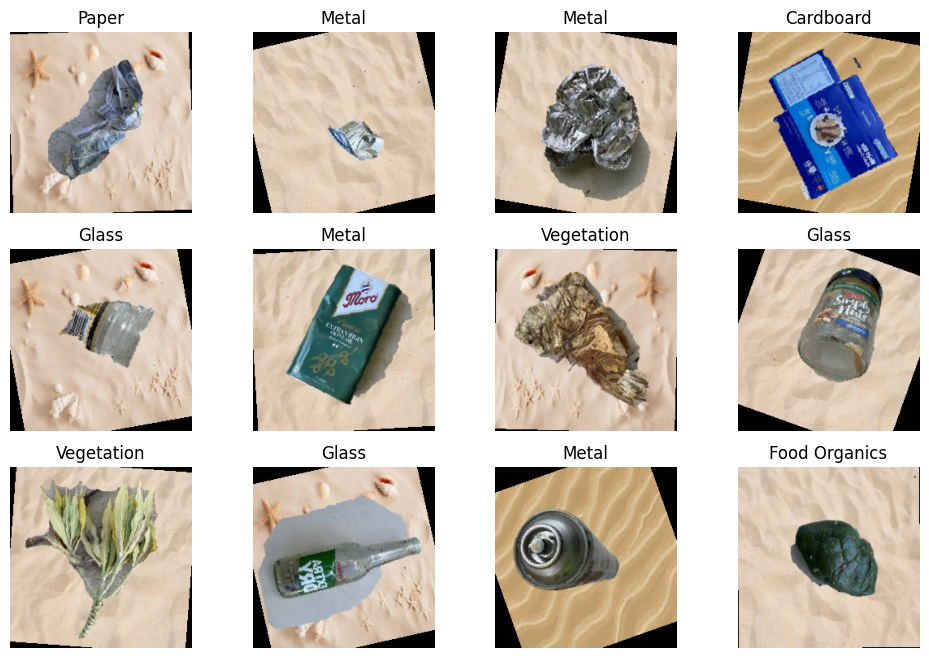

In [16]:
images, labels = next(iter(train_loader))

mean = torch.tensor([0.485,0.456,0.406]).reshape(3,1,1)
std = torch.tensor([0.229,0.224,0.225]).reshape(3,1,1)

plt.figure(figsize=(12,8))
for i in range(12):
    img = images[i] * std + mean
    img = img.permute(1,2,0).numpy()

    plt.subplot(3,4,i+1)
    plt.imshow(np.clip(img,0,1))
    plt.title(full_train_dataset.classes[labels[i]])
    plt.axis("off")

plt.show()


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28,256), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

cnn = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

cnn


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=9, bias=True)
  )
)

In [18]:
def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0,0,0

    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs,1)
        correct += (preds==y).sum().item()
        total += X.size(0)
        loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total

def eval_epoch(model, loader):
    model.eval()
    total, correct, loss_sum = 0,0,0

    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs,y)

            _, preds = torch.max(outputs,1)
            correct += (preds==y).sum().item()
            total += X.size(0)
            loss_sum += loss.item()*X.size(0)

    return loss_sum/total, correct/total


history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}

for epoch in range(1,16):
    tr_loss, tr_acc = train_epoch(cnn, train_loader)
    val_loss, val_acc = eval_epoch(cnn, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"[{epoch}/15] Train Acc={tr_acc:.3f} | Val Acc={val_acc:.3f}")


[1/15] Train Acc=0.236 | Val Acc=0.260
[2/15] Train Acc=0.291 | Val Acc=0.319
[3/15] Train Acc=0.351 | Val Acc=0.365
[4/15] Train Acc=0.385 | Val Acc=0.382
[5/15] Train Acc=0.396 | Val Acc=0.391
[6/15] Train Acc=0.431 | Val Acc=0.395
[7/15] Train Acc=0.436 | Val Acc=0.466
[8/15] Train Acc=0.473 | Val Acc=0.495
[9/15] Train Acc=0.498 | Val Acc=0.509
[10/15] Train Acc=0.497 | Val Acc=0.505
[11/15] Train Acc=0.530 | Val Acc=0.502
[12/15] Train Acc=0.545 | Val Acc=0.516
[13/15] Train Acc=0.568 | Val Acc=0.509
[14/15] Train Acc=0.587 | Val Acc=0.516
[15/15] Train Acc=0.610 | Val Acc=0.543


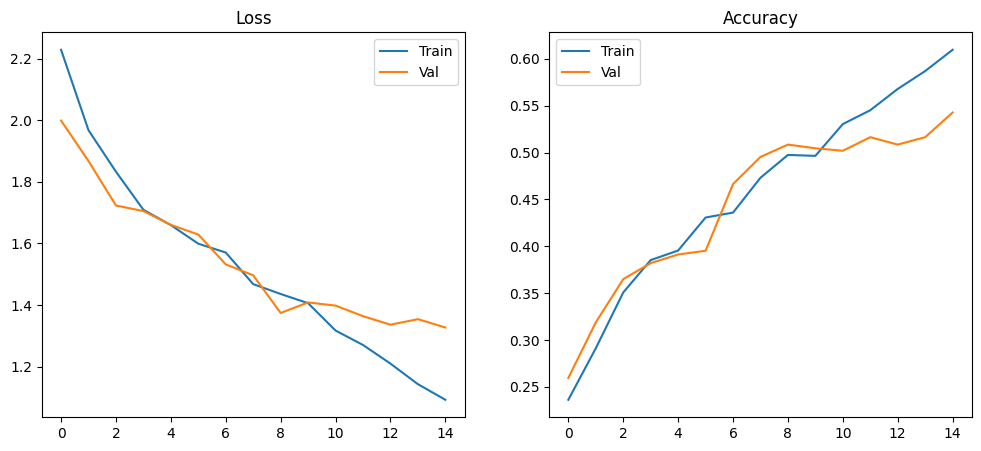

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy"); plt.legend()

plt.show()


                     precision    recall  f1-score   support

          Cardboard       0.40      0.47      0.44        93
      Food Organics       0.49      0.57      0.53        83
              Glass       0.71      0.58      0.64        84
              Metal       0.54      0.74      0.63       158
Miscellaneous Trash       0.33      0.17      0.23        99
              Paper       0.61      0.39      0.48       100
            Plastic       0.47      0.63      0.54       185
      Textile Trash       0.42      0.16      0.23        64
         Vegetation       0.83      0.70      0.76        88

           accuracy                           0.53       954
          macro avg       0.53      0.49      0.50       954
       weighted avg       0.53      0.53      0.51       954



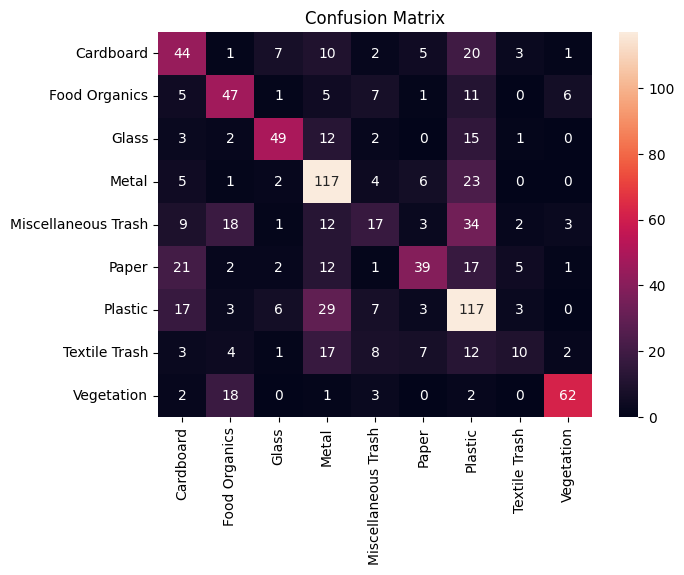

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

cnn.eval()
preds, gts = [], []

with torch.no_grad():
    for X,y in test_loader:
        X = X.to(device)
        outputs = cnn(X)
        _, batch_preds = torch.max(outputs,1)

        preds.extend(batch_preds.cpu().numpy())
        gts.extend(y.numpy())

print(classification_report(gts, preds, target_names=full_train_dataset.classes))

cm = confusion_matrix(gts, preds)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
    xticklabels=full_train_dataset.classes,
    yticklabels=full_train_dataset.classes)
plt.title("Confusion Matrix")
plt.show()


In [22]:
torch.save(cnn.state_dict(), "mon_modele.pth")

**Mobile netV2**

In [23]:
import torch
import torch.nn as nn
from torchvision import models

def build_mobilenet_v2(num_classes):
    # Charger MobileNetV2 pré-entraîné
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # On récupère la taille de l’entrée du dernier classifier
    in_features = model.classifier[1].in_features

    # Remplacer la dernière couche par notre propre classifier
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [24]:
mobilenet = build_mobilenet_v2(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)  # lr plus petit !


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\paull/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 45.3MB/s]


In [25]:
mobilenet_transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

mobilenet_transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [26]:
num_epochs = 10
history_mob = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": []
}

for epoch in range(num_epochs):
    # TRAIN
    mobilenet.train()
    running_loss, running_corrects, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * X.size(0)
        running_corrects += (preds == y).sum().item()
        total += X.size(0)

    train_loss = running_loss / total
    train_acc = running_corrects / total

    # VAL
    mobilenet.eval()
    val_loss, val_corrects, val_total = 0, 0, 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = mobilenet(X)
            loss = criterion(outputs, y)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * X.size(0)
            val_corrects += (preds == y).sum().item()
            val_total += X.size(0)

    val_loss = val_loss / val_total
    val_acc = val_corrects / val_total

    history_mob["train_loss"].append(train_loss)
    history_mob["train_acc"].append(train_acc)
    history_mob["val_loss"].append(val_loss)
    history_mob["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")


[1/10] Train Acc=0.552 | Val Acc=0.692
[2/10] Train Acc=0.754 | Val Acc=0.775
[3/10] Train Acc=0.832 | Val Acc=0.780
[4/10] Train Acc=0.873 | Val Acc=0.792
[5/10] Train Acc=0.902 | Val Acc=0.798
[6/10] Train Acc=0.928 | Val Acc=0.801
[7/10] Train Acc=0.943 | Val Acc=0.819
[8/10] Train Acc=0.960 | Val Acc=0.814
[9/10] Train Acc=0.966 | Val Acc=0.806
[10/10] Train Acc=0.969 | Val Acc=0.821


Classification report (MobileNetV2 sur test) :

                     precision    recall  f1-score   support

          Cardboard       0.79      0.83      0.81        93
      Food Organics       0.91      0.90      0.91        83
              Glass       0.90      0.82      0.86        84
              Metal       0.78      0.90      0.84       158
Miscellaneous Trash       0.81      0.74      0.77        99
              Paper       0.93      0.82      0.87       100
            Plastic       0.80      0.83      0.81       185
      Textile Trash       0.87      0.75      0.81        64
         Vegetation       0.90      0.94      0.92        88

           accuracy                           0.84       954
          macro avg       0.86      0.84      0.84       954
       weighted avg       0.84      0.84      0.84       954



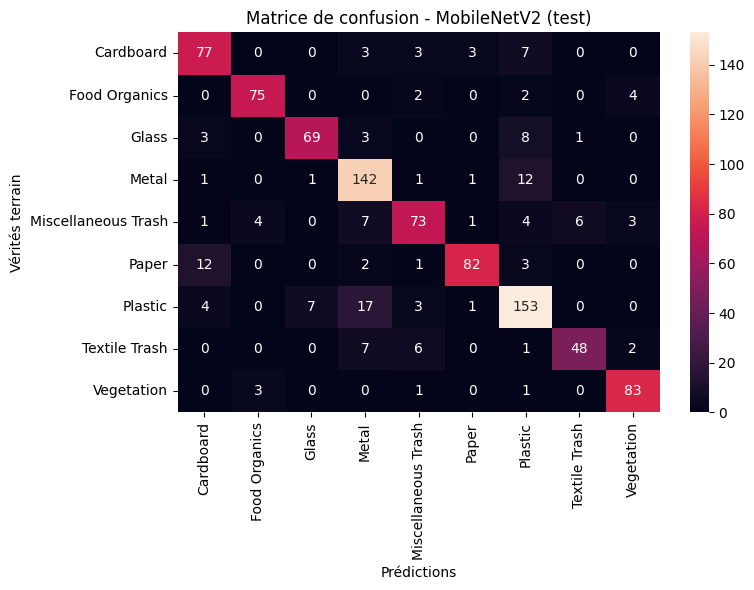

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mobilenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:          # ← ici on utilise bien le dossier test/
        X, y = X.to(device), y.to(device)
        outputs = mobilenet(X)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report (MobileNetV2 sur test) :\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion - MobileNetV2 (test)")
plt.tight_layout()
plt.show()


In [28]:
# Sauvegarde des poids
torch.save(mobilenet.state_dict(), "mobilenet_v2_trash.pth")

# Sauvegarde des classes (ordre EXACT utilisé pour l'entraînement)
import json
with open("classes.json", "w") as f:
    json.dump(full_train_dataset.classes, f)
